In [19]:
# INSPIRED BY https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("binary classifier") \
    .getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [20]:
df_pd = df.toPandas()
df_pd.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [21]:
# check if there are some NaN values
df_pd.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [24]:
# check the balance of classes
df_pd.groupby(['deposit'])[["deposit"]].count()

deposit
deposit         
no          5873
yes         5289

In [25]:
# there is a balance

In [26]:
# check formats
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [27]:
#Show numeric columns

numeric_columns = [t[0] for t in df.dtypes if t[1] == 'int']
df_pd[numeric_columns].describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

In [28]:
df_numeric = df_pd[numeric_columns]
(df_numeric > 0).all(0)

age          True
balance     False
day          True
duration     True
campaign     True
pdays       False
previous    False
dtype: bool

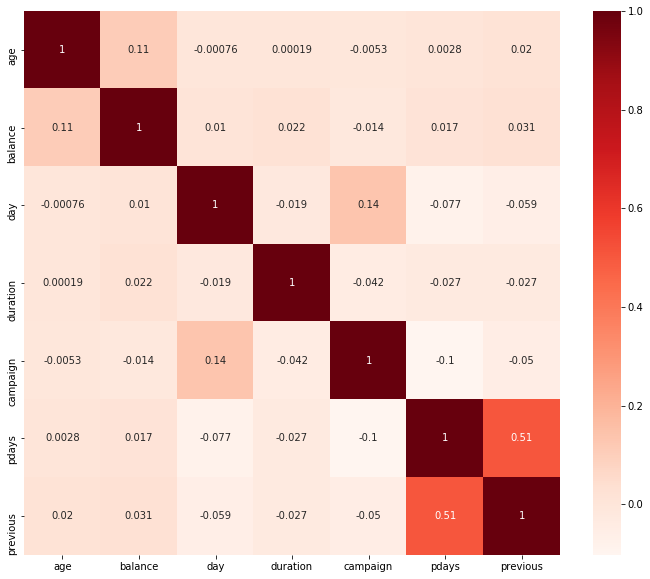

In [29]:
# check if there is correlation between numerical variables
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_pd[numeric_columns].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
# seems that "previous" and "pdays" are correlated, so pdays are not considered anymore
# it is said, that column duration shouldnt be include, because it highly affects the output target, but the results are much worse if we drop it
df = df.select('age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','day','month','duration','campaign', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [32]:
# preparing data for analysis, changing categorical to numerical and map all data into one column "features"

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age','duration', 'campaign']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [33]:
# Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
pd.DataFrame(df.take(5), columns=df.columns)

age         job  marital  education default housing loan  contact  day  \
0   59      admin.  married  secondary      no     yes   no  unknown    5   
1   56      admin.  married  secondary      no      no   no  unknown    5   
2   41  technician  married  secondary      no     yes   no  unknown    5   
3   55    services  married  secondary      no     yes   no  unknown    5   
4   54      admin.  married   tertiary      no      no   no  unknown    5   

  month  ...  loanIndex  loanclassVec contactIndex contactclassVec  \
0   may  ...        0.0         (1.0)          1.0      (0.0, 1.0)   
1   may  ...        0.0         (1.0)          1.0      (0.0, 1.0)   
2   may  ...        0.0         (1.0)          1.0      (0.0, 1.0)   
3   may  ...        0.0         (1.0)          1.0      (0.0, 1.0)   
4   may  ...        0.0         (1.0)          1.0      (0.0, 1.0)   

   monthIndex                                      monthclassVec  \
0         0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1         0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2         0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3         0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4         0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

   poutcomeIndex poutcomeclassVec  label  \
0            0.0  (1.0, 0.0, 0.0)    1.0   
1            0.0  (1.0, 0.0, 0.0)    1.0   
2            0.0  (1.0, 0.0, 0.0)    1.0   
3            0.0  (1.0, 0.0, 0.0)    1.0   
4            0.0  (1.0, 0.0, 0.0)    1.0   

                                            features  
0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
4  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[5 rows x 34 columns]

In [34]:
from pyspark.ml.feature import StandardScaler

standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
df=standardscaler.fit(df).transform(df)
df.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(38,[3,11,13,16,1...|(38,[3,11,13,16,1...|
|(38,[3,11,13,16,1...|(38,[3,11,13,16,1...|
|(38,[2,11,13,16,1...|(38,[2,11,13,16,1...|
|(38,[4,11,13,16,1...|(38,[4,11,13,16,1...|
|(38,[3,11,14,16,1...|(38,[3,11,14,16,1...|
+--------------------+--------------------+
only showing top 5 rows



In [35]:
# Now we build trainining set and test set for prediction
train, test = df.randomSplit([0.6, 0.4], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 6649
Test Dataset Count: 4513


In [36]:
# Logistic Regression

In [37]:
from pyspark.ml.classification import LogisticRegression
# Build the model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
# Train model with Training Data
lrModel = lr.fit(train)


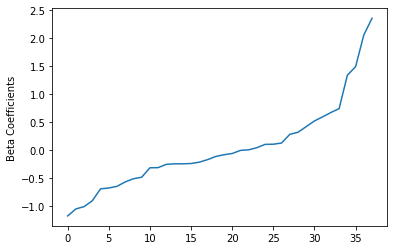

In [38]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [39]:
# log odds that the response value is a '1' 

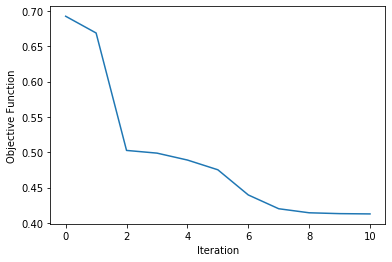

In [40]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

In [41]:
# shows how our training is going at every iteration.

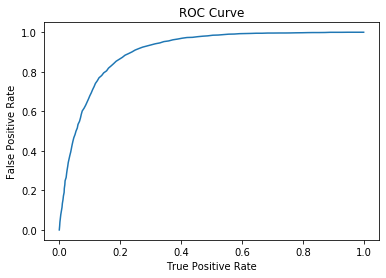

Training set areaUnderROC: 0.9038541054305773


In [42]:
# ROC Curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [43]:
# The AUC thus gives the probability that the model correctly ranks observations
# True Positive - correctly predicted "1"
# False Positive - incorrectly predicted "0"

# The greater te areaUnderROC is, the better model fit to data

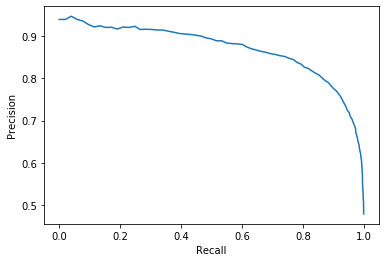

In [44]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [45]:
# Precision = TP / (TP+FP) 
# Recall = TP / (TP+FN) 
#where
#True Positive - (TP) 
#False Positive - (FP) 
#True Negative - (TN) 
#False Negative -(FN) 

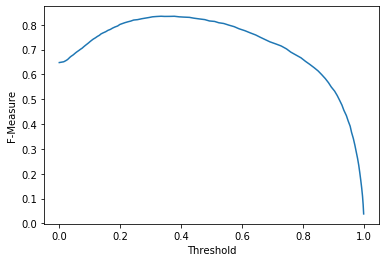

In [46]:
# Set the model threshold to maximize F-Measure

f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [47]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(test)

predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(n=10, truncate=20)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[-1.2531107568504...|       1.0|[0.22216211646197...|
| 18|    student|  1.0|[-1.9589371427875...|       1.0|[0.12358211913391...|
| 19|    student|  1.0|[0.03841203490574...|       0.0|[0.50960182814314...|
| 19|    student|  1.0|[-3.7264775002437...|       1.0|[0.02351140380540...|
| 19|    student|  1.0|[-6.3861151026221...|       1.0|[0.00168195499656...|
| 19|    student|  1.0|[-3.0037362107958...|       1.0|[0.04725736877594...|
| 20|blue-collar|  1.0|[-1.0335179211643...|       1.0|[0.26240265043240...|
| 20|    student|  1.0|[0.33634649842401...|       0.0|[0.58330277164576...|
| 20|    student|  0.0|[-1.0869555651013...|       1.0|[0.25219199872905...|
| 20|    student|  1.0|[-0.9437123720694...|       1.0|[0.28015107102740...|

In [48]:

predictions.filter(predictions['prediction'] == 0) \
    .select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability') \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 20)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 42|blue-collar|  0.0|[8.48018218900060...|       0.0|[0.99979250217667...|
| 33|blue-collar|  0.0|[8.10484933375022...|       0.0|[0.99969802048042...|
| 44|   services|  0.0|[6.69624576444634...|       0.0|[0.99876598295836...|
| 58|     admin.|  0.0|[6.27139141769052...|       0.0|[0.99811396631085...|
| 28|   services|  0.0|[6.03334838817046...|       0.0|[0.99760828111259...|
| 38|blue-collar|  0.0|[5.89587190620153...|       0.0|[0.99725676913828...|
| 52| management|  0.0|[5.68290003440094...|       0.0|[0.99660787234751...|
| 55|   services|  0.0|[5.66679069308663...|       0.0|[0.99655297477319...|
| 50|blue-collar|  0.0|[5.49564177338993...|       0.0|[0.99591215766177...|
| 55|blue-collar|  0.0|[5.26264135602597...|       0.0|[0.99484511040032...|

In [49]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.9038541054305773
Test: Area Under ROC: 0.8992387875056878


In [50]:
# Cross Validator

In [51]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder().build())

# Create 10-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=10)

# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(test)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.8992387875056878


In [52]:
# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------+----------+--------------------+
|age|        job|label| rawPrediction|prediction|         probability|
+---+-----------+-----+--------------+----------+--------------------+
| 18|    student|  1.0| [289.0,755.0]|       1.0|[0.27681992337164...|
| 18|    student|  1.0|[2824.0,904.0]|       0.0|[0.75751072961373...|
| 19|    student|  1.0|[2824.0,904.0]|       0.0|[0.75751072961373...|
| 19|    student|  1.0|  [39.0,375.0]|       1.0|[0.09420289855072...|
| 19|    student|  1.0|  [39.0,375.0]|       1.0|[0.09420289855072...|
| 19|    student|  1.0|  [39.0,375.0]|       1.0|[0.09420289855072...|
| 20|blue-collar|  1.0| [289.0,755.0]|       1.0|[0.27681992337164...|
| 20|    student|  1.0|[2824.0,904.0]|       0.0|[0.75751072961373...|
| 20|    student|  0.0|[2824.0,904.0]|       0.0|[0.75751072961373...|
| 20|    student|  1.0|[2824.0,904.0]|       0.0|[0.75751072961373...|
+---+-----------+-----+--------------+----------+--------------------+
only s

In [53]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5166849176142361


In [54]:
#Gradient-Boosted Tree Classifier

In [55]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[-0.5192461421239...|       1.0|[0.26144101343341...|
| 18|    student|  1.0|[-0.2261150976602...|       1.0|[0.38883064815573...|
| 19|    student|  1.0|[-0.1825247482277...|       1.0|[0.40973777716337...|
| 19|    student|  1.0|[-1.3496071171758...|       1.0|[0.06301973821572...|
| 19|    student|  1.0|[-1.3352379863766...|       1.0|[0.06473814385784...|
| 19|    student|  1.0|[-1.2340336556351...|       1.0|[0.07812732057827...|
| 20|blue-collar|  1.0|[-0.6793889320163...|       1.0|[0.20443900319763...|
| 20|    student|  1.0|[-0.1899527367012...|       1.0|[0.40614969593407...|
| 20|    student|  0.0|[-0.6843852576791...|       1.0|[0.20281856080147...|
| 20|    student|  1.0|[-0.2919990849136...|       1.0|[0.35801313465066...|

In [56]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8954956661398549


In [57]:
#Random Forest

In [58]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[6.60456893597201...|       1.0|[0.33022844679860...|
| 18|    student|  1.0|[10.1137433737768...|       0.0|[0.50568716868884...|
| 19|    student|  1.0|[11.5712731460199...|       0.0|[0.57856365730099...|
| 19|    student|  1.0|[3.97500565744802...|       1.0|[0.19875028287240...|
| 19|    student|  1.0|[3.57574586752895...|       1.0|[0.17878729337644...|
| 19|    student|  1.0|[4.16937296354970...|       1.0|[0.20846864817748...|
| 20|blue-collar|  1.0|[7.56318460777950...|       1.0|[0.37815923038897...|
| 20|    student|  1.0|[12.8659313659322...|       0.0|[0.64329656829661...|
| 20|    student|  0.0|[8.05735601928322...|       1.0|[0.40286780096416...|
| 20|    student|  1.0|[8.37907166268033...|       1.0|[0.41895358313401...|

In [59]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.892063698766626


In [69]:
# Naive Bayes Classifier
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label',smoothing=1.0, modelType="multinomial")
nbModel = nb.fit(train)
predictions = nbModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[-198.26992812396...|       1.0|[4.30356781940899...|
| 18|    student|  1.0|[-131.34601515528...|       1.0|[0.07349783674979...|
| 19|    student|  1.0|[-144.10296261437...|       1.0|[0.04713723660879...|
| 19|    student|  1.0|[-141.51847512856...|       1.0|[0.07430049907575...|
| 19|    student|  1.0|[-163.85288270538...|       1.0|[1.28127147624924...|
| 19|    student|  1.0|[-134.15414439842...|       1.0|[0.07685277741744...|
| 20|blue-collar|  1.0|[-198.81542221118...|       1.0|[3.00875806238744...|
| 20|    student|  1.0|[-146.31176535275...|       0.0|[0.86719811037215...|
| 20|    student|  0.0|[-155.60772232077...|       1.0|[1.76884234882708...|
| 20|    student|  1.0|[-164.40307029881...|       1.0|[0.00323447560019...|

In [70]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.334572030077561


In [ ]:
# Naive Bayes is worst of all classifiers

In [37]:
#Logistic Regression Model seem to be the best of all models.

In [ ]:
# Without duration column

In [92]:
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("binary classifier") \
    .getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact','day','month','campaign','previous', 'poutcome', 'deposit')
cols = df.columns

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact','month', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'campaign', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
pd.DataFrame(df.take(5), columns=df.columns)



age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day  ... loanIndex  loanclassVec  contactIndex contactclassVec monthIndex  \
0    5  ...       0.0         (1.0)           1.0      (0.0, 1.0)        0.0   
1    5  ...       0.0         (1.0)           1.0      (0.0, 1.0)        0.0   
2    5  ...       0.0         (1.0)           1.0      (0.0, 1.0)        0.0   
3    5  ...       0.0         (1.0)           1.0      (0.0, 1.0)        0.0   
4    5  ...       0.0         (1.0)           1.0      (0.0, 1.0)        0.0   

                                       monthclassVec poutcomeIndex  \
0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0.0   
1  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0.0   
2  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0.0   
3  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0.0   
4  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...           0.0   

   poutcomeclassVec label                                           features  
0   (1.0, 0.0, 0.0)   1.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1   (1.0, 0.0, 0.0)   1.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2   (1.0, 0.0, 0.0)   1.0  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3   (1.0, 0.0, 0.0)   1.0  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
4   (1.0, 0.0, 0.0)   1.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[5 rows x 35 columns]

In [72]:
from pyspark.ml.feature import StandardScaler

standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
df=standardscaler.fit(df).transform(df)

# Now we build trainining set and test set for prediction
train, test = df.randomSplit([0.6, 0.4], seed = 2018)



In [73]:
# Logistic regression

In [74]:
from pyspark.ml.classification import LogisticRegression
# Build the model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
# Train model with Training Data
lrModel = lr.fit(train)


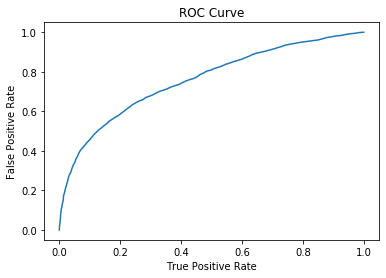

Training set areaUnderROC: 0.75851740279026


In [75]:
# ROC Curve
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [76]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))
predictions = lrModel.transform(test)
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.75851740279026
Test: Area Under ROC: 0.7702404608340294


In [77]:
# With "duration" it was
# Training: Area Under ROC: 0.9012993143472836
# Test: Area Under ROC: 0.9046435921421858

In [78]:
# Cross validator

In [91]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder().build())

# Create 10-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=10)

# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(test)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.7702404608340294


In [80]:
# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+---------------+----------+--------------------+
|age|        job|label|  rawPrediction|prediction|         probability|
+---+-----------+-----+---------------+----------+--------------------+
| 18|    student|  1.0|[1203.0,1497.0]|       1.0|[0.44555555555555...|
| 18|    student|  1.0|[1203.0,1497.0]|       1.0|[0.44555555555555...|
| 19|    student|  1.0|[1203.0,1497.0]|       1.0|[0.44555555555555...|
| 19|    student|  1.0|   [52.0,560.0]|       1.0|[0.08496732026143...|
| 19|    student|  1.0|   [52.0,560.0]|       1.0|[0.08496732026143...|
| 19|    student|  1.0|   [52.0,560.0]|       1.0|[0.08496732026143...|
| 20|blue-collar|  1.0| [1200.0,775.0]|       0.0|[0.60759493670886...|
| 20|    student|  0.0|[1203.0,1497.0]|       1.0|[0.44555555555555...|
| 20|    student|  1.0|[1203.0,1497.0]|       1.0|[0.44555555555555...|
| 20|    student|  0.0|[1203.0,1497.0]|       1.0|[0.44555555555555...|
+---+-----------+-----+---------------+----------+--------------

In [81]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5903166756929742


In [82]:
# With "duration" column it was
# Test Area Under ROC: 0.5007443257348235


In [83]:
#Gradient-Boosted Tree Classifier

In [84]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[0.18831199931676...|       0.0|[0.59305859509815...|
| 18|    student|  1.0|[-0.6092797650041...|       1.0|[0.22819004587513...|
| 19|    student|  1.0|[-0.2061929103529...|       1.0|[0.39834018431216...|
| 19|    student|  1.0|[-1.2386676658577...|       1.0|[0.07746241035026...|
| 19|    student|  1.0|[-1.0555613876321...|       1.0|[0.10802043747352...|
| 19|    student|  1.0|[-1.1619548830911...|       1.0|[0.08916202833090...|
| 20|blue-collar|  1.0|[0.14781053393758...|       0.0|[0.57337170310600...|
| 20|    student|  0.0|[-0.1995900509622...|       1.0|[0.40150934513999...|
| 20|    student|  1.0|[0.12138703991951...|       0.0|[0.56039716397240...|
| 20|    student|  0.0|[-0.3067297569189...|       1.0|[0.35127044051875...|

In [85]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7746574762443994


In [86]:
# With "duration":
# Test Area Under ROC: 0.9013981586332539

In [87]:
# Random Forest

In [88]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[9.57374180537332...|       1.0|[0.47868709026866...|
| 18|    student|  1.0|[7.31738367991446...|       1.0|[0.36586918399572...|
| 19|    student|  1.0|[8.52416181044900...|       1.0|[0.42620809052245...|
| 19|    student|  1.0|[3.99333391470748...|       1.0|[0.19966669573537...|
| 19|    student|  1.0|[3.11209651095405...|       1.0|[0.15560482554770...|
| 19|    student|  1.0|[3.71432156326081...|       1.0|[0.18571607816304...|
| 20|blue-collar|  1.0|[11.6568812042755...|       0.0|[0.58284406021377...|
| 20|    student|  0.0|[6.67757843567724...|       1.0|[0.33387892178386...|
| 20|    student|  1.0|[9.00555491305197...|       1.0|[0.45027774565259...|
| 20|    student|  0.0|[11.423371414552,...|       0.0|[0.5711685707276,...|

In [89]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7739440697159155


In [90]:
# With duration:
#Test Area Under ROC: 0.8875091329821284